In [58]:
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np 
from myutils import Helpers as h
from myutils import Complexity_Measures as cm
from myutils import Datasets as ds
import itertools
import os

#Magic Command, so changes in myutils module are reloaded
%load_ext autoreload
%autoreload 1
%aimport myutils


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Explore Data
- random: generates random pixels with random label , expected to have the greatest complextity
- all_numbers: contains all numbers, expected to have lower complextiy than random
- six_and_nines: only take 6 and 9s , expected to have lower complexity tahn all numbers
- only_sixes: only take 6es, execpted to have lowest complexity

In [2]:
data = ds.get_all_data()


ALL_NUMBERS number of examples 60000


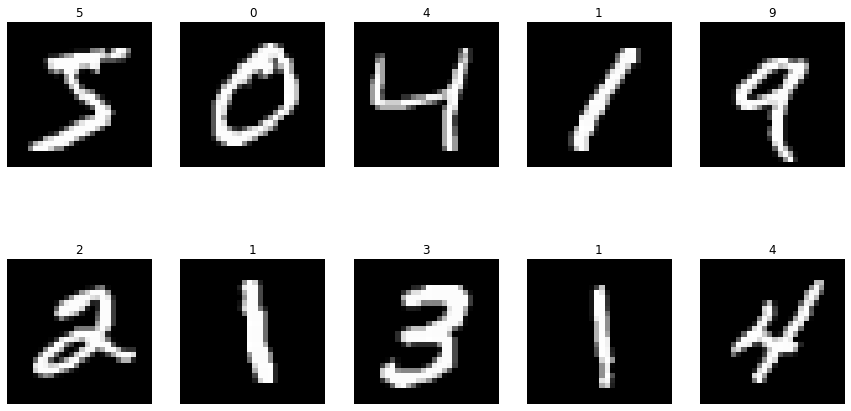

PCA


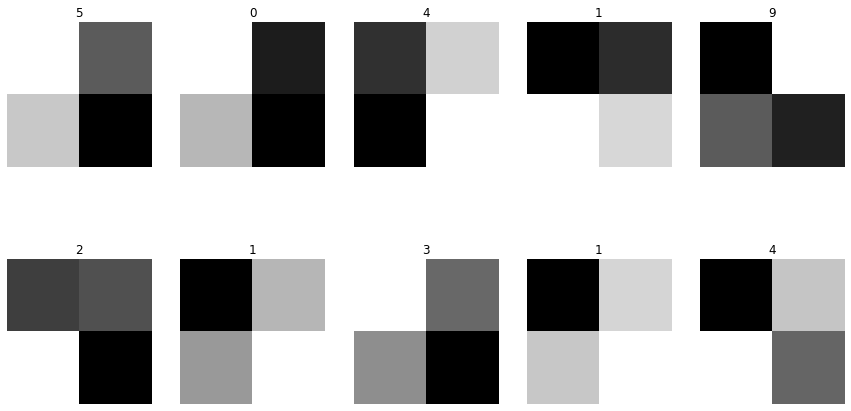

SIX_AND_NINES number of examples 11867


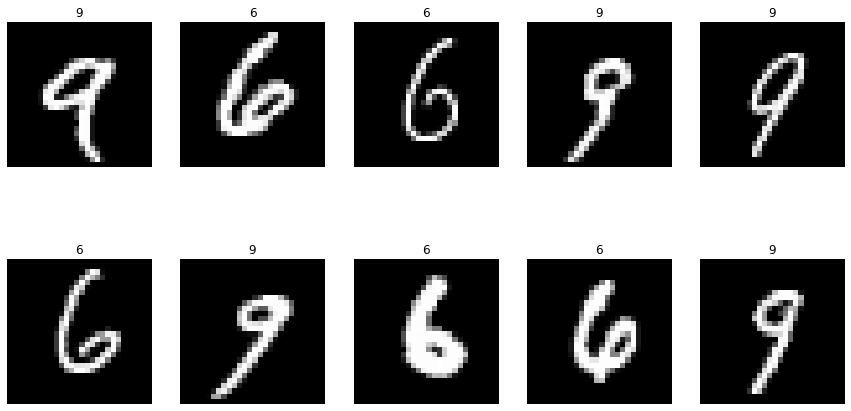

PCA


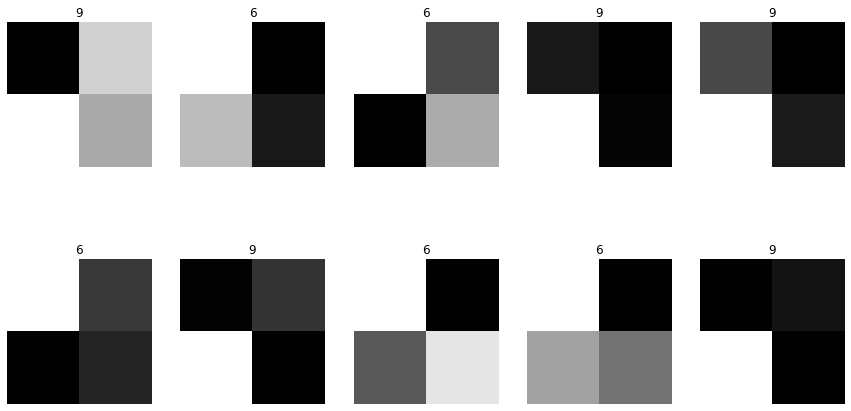

ONLY_SIXES number of examples 5918


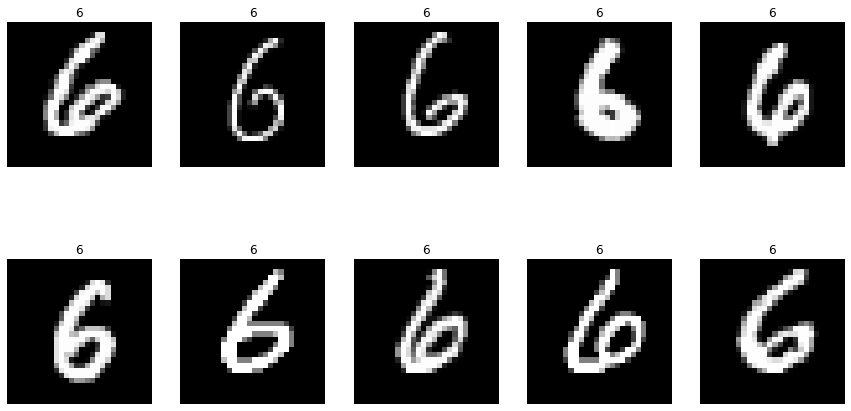

PCA


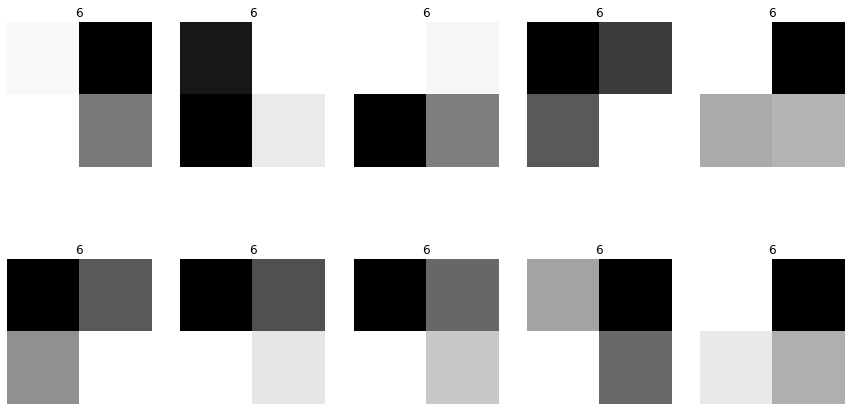

RANDOM number of examples 60000


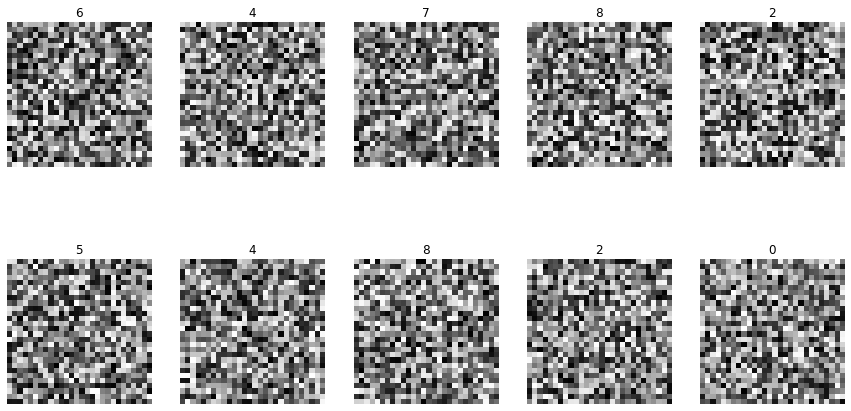

PCA


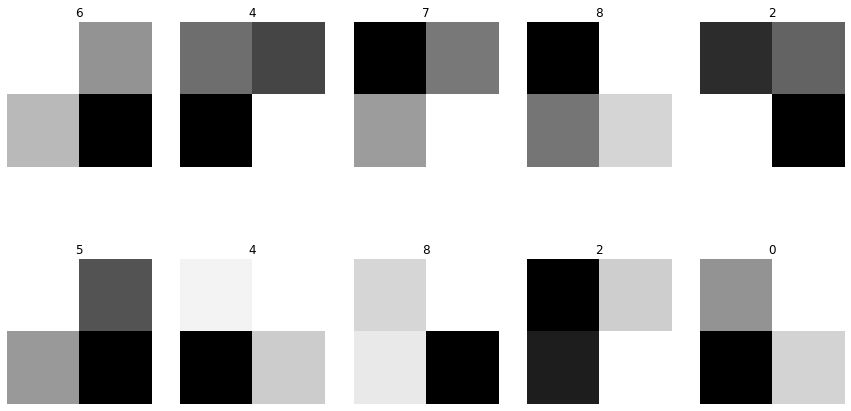

SAMEPICTURE number of examples 60000


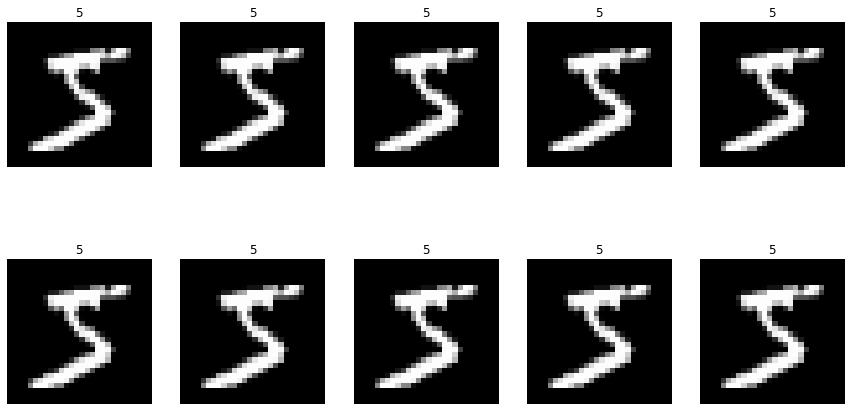

PCA


/Users/felixbieswanger/miniforge3/envs/tfm1/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:595: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var.sum()


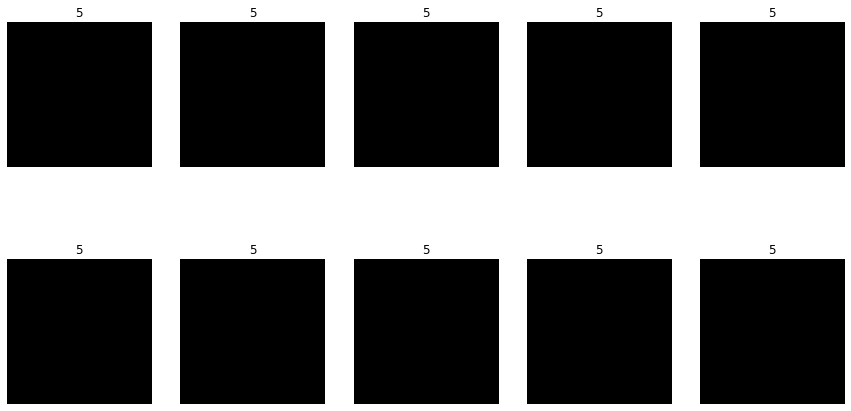

In [3]:
rows = 2
cols = 5

for dataset in data:
    print(dataset,"number of examples",len(data[dataset]["x_train"]))
    h.plot_grid(data[dataset]["x_train"],labels=data[dataset]["y_train"] , rows=rows, cols=cols)

    print("PCA")
    data[dataset]["x_train_pca"] = h.PCA(data[dataset]["x_train"],n_components=4)
    h.plot_grid(data[dataset]["x_train_pca"],labels=data[dataset]["y_train"] , rows=rows, cols=cols)

# Test classification to be performed only with the result of the PCA.

On the test plot you can see that it seems that the 6s and 9s always look about the same. For the classification the simplest possibility was used: if the pixel in the upper left corner is white -> 6 otherwise 9. This gives a surprisingly good accuracy of 82%.

-> thus the assumption that the variational_circuit does not "perform" so much or has to solve an already simple problem.

Normalize values between 0 and 255, because PCA moves value range

In [ ]:
six_nine_pca_normalized = h.normalize(data["SIX_AND_NINES"]["x_train_pca"])

In [ ]:
predictions = list()
for i in range(len(data["SIX_AND_NINES"]["x_train_pca"])):
    if six_nine_pca_normalized[i][0][0] > 150:
        predictions.append(6)
    else:
        predictions.append(9)

In [ ]:
h.plot_classify_results(predictions=predictions,labels=data["SIX_AND_NINES"]["y_train"])

# Entropy Measure
For each created dataset, take 4000 random samples (since dataset sizes are not equal -> all numbers > six&nines > only sixes). Calculate the entropy like proposed in paper below.
  
Like expected the random dataset gets the largest entropy. But the other dataset aren't to different from each other, which ist not what our hope was (Because the dataset with all numbers is cleary more "complex" than the dataset with only sixes). Especially the six&nine dataset is only slightly higher entropy than only sixes.
  
Also the entropy for all pixels get plotet.



*Rahane, A. A., & Subramanian, A. (2020). Measures of Complexity for Large Scale Image Datasets. 2020 International Conference on Artificial Intelligence in Information and Communication (ICAIIC), 282–287. https://doi.org/10.1109/ICAIIC48513.2020.9065274*

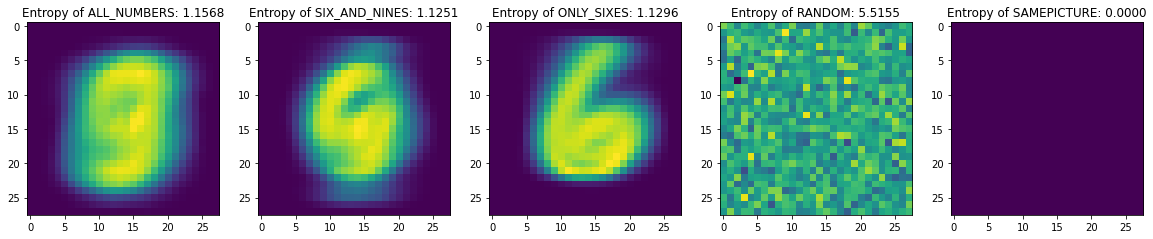

In [3]:
fig, ax = plt.subplots(1,len(data),figsize=(20,10))
i = 0

for dataset in data:
    d_set = data[dataset]["x_train"]
    np.random.shuffle(d_set)
    np.random.seed(1337)
    d_set = d_set[:5000]

    entropy = cm.entropy(d_set)

    ax[i].set_title("Entropy of {}: {:.4f}".format(dataset, entropy.mean()))

    ax[i].imshow(entropy.reshape(d_set.shape[1], d_set.shape[2]),cmap="viridis")
    i+=1

plt.show()



Entropy of  ALL_NUMBERS 1.0009108350881717


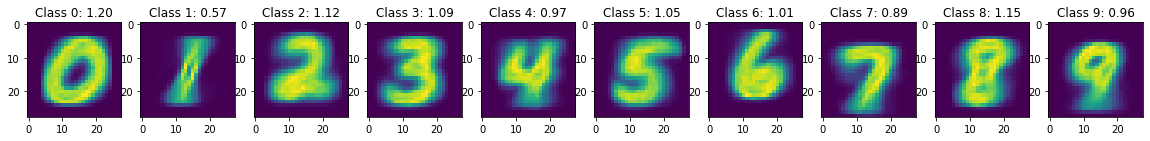

Entropy of  SIX_AND_NINES 1.0771777423277298


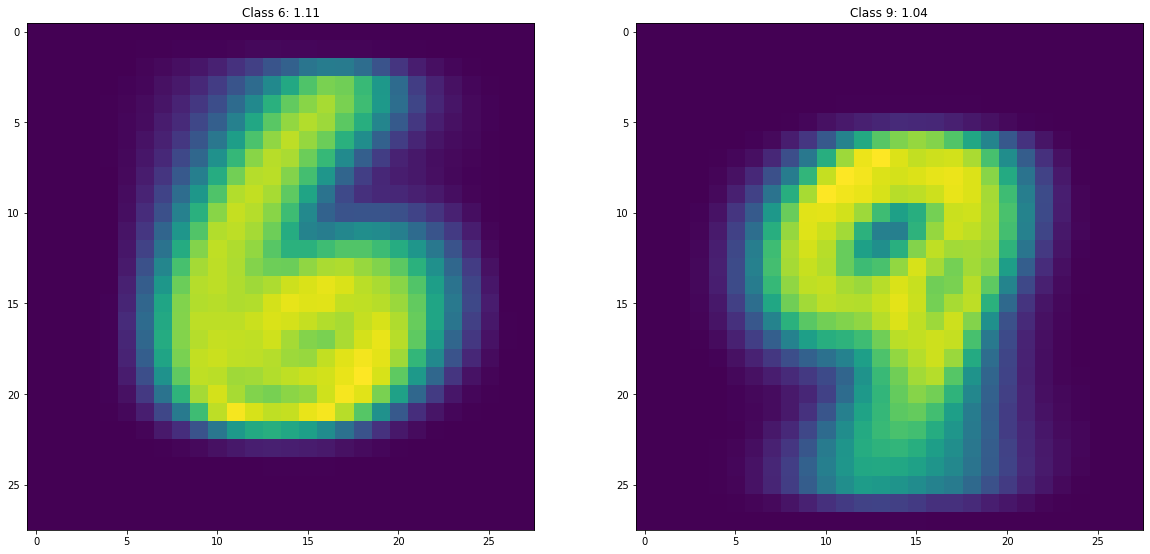

In [31]:

for dataset in data:
    if dataset in ["SIX_AND_NINES","ALL_NUMBERS"]:
        randomize = np.arange(5000)
        np.random.shuffle(randomize)
        x , y = data[dataset]["x_train"][randomize], data[dataset]["y_train"][randomize]
        y_unique = np.unique(y)

        fig, ax = plt.subplots(1,len(y_unique),figsize=(20,20))
        i = 0
       
        entropy_overall = np.zeros(len(y_unique))
        for y_class in y_unique:
            x_class = x[y == y_class]

            entropy = cm.entropy(x_class)
            entropy_overall[i] = entropy.mean()
            ax[i].set_title("Class {}: {:.2f}".format(y_class,entropy.mean()))
            ax[i].imshow(entropy.reshape(x_class.shape[1], x_class.shape[2]),cmap="viridis")
            i+=1
        print("Entropy of ",dataset, np.mean(entropy_overall))
        plt.show()

    


You can see that all 3 datasets have about the same entropy after applying PCA. This means either PCA is unsuitable or entropy. For further comments or mistakes I made, I would be grateful at this point :) 

Entropy of  ALL_NUMBERS 4.427100276842273
Entropy of  SIX_AND_NINES 4.917846972616407


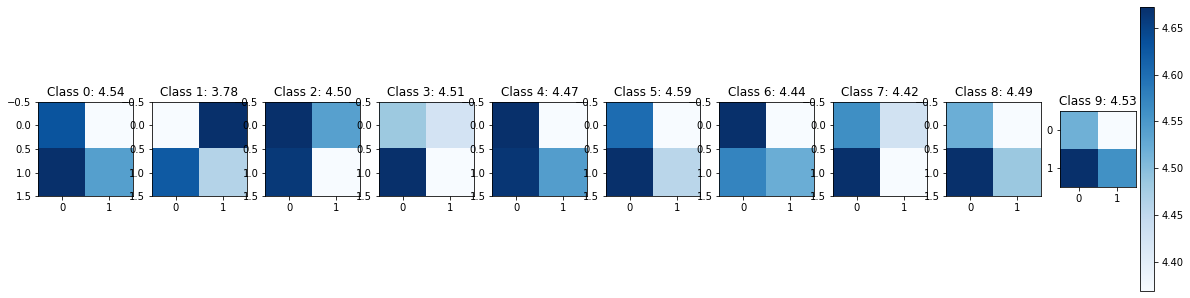

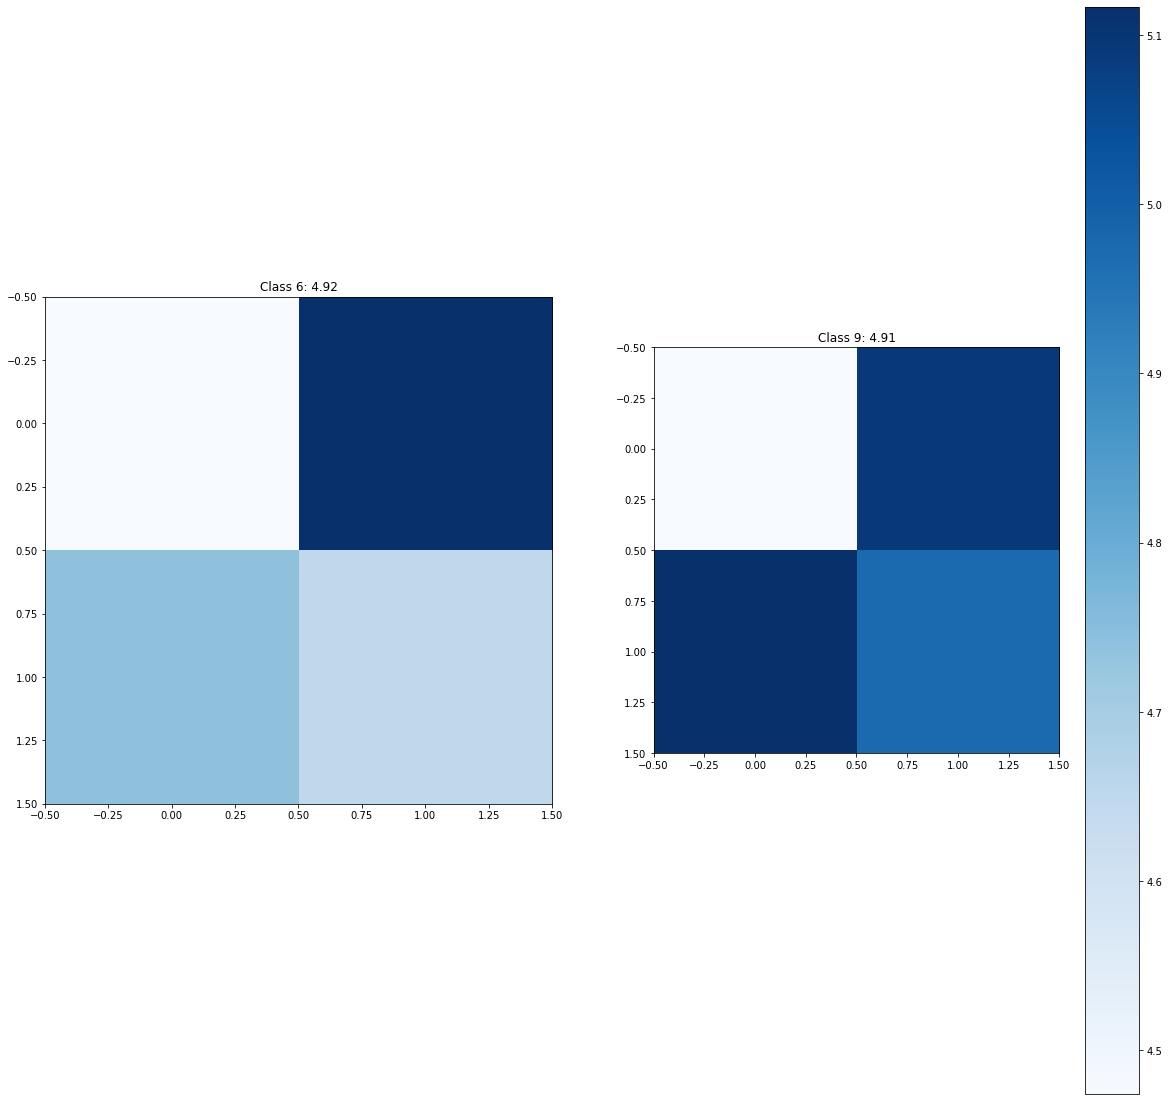

In [49]:
for dataset in data:
    if dataset in ["SIX_AND_NINES","ALL_NUMBERS"]:
        randomize = np.arange(5000)
        np.random.shuffle(randomize)
        x , y = data[dataset]["x_train_pca"][randomize], data[dataset]["y_train"][randomize]
        x = h.normalize(x)
        y_unique = np.unique(y)

        fig, ax = plt.subplots(1,len(y_unique),figsize=(20,20))
        i = 0
       
        entropy_overall = np.zeros(len(y_unique))
        for y_class in y_unique:
            x_class = x[y == y_class]

            entropy = cm.entropy(x_class)
            entropy_overall[i] = entropy.mean()
            ax[i].set_title("Class {}: {:.2f}".format(y_class,entropy.mean()))
            plot = ax[i].imshow(entropy.reshape(x_class.shape[1], x_class.shape[2]),cmap="Blues")
            i+=1
        print("Entropy of ",dataset, np.mean(entropy_overall))
        plt.colorbar(plot,ax = ax[-1])
plt.show()


Man muss den Entropy ja deuten > je kleiner der Wert, desto geringer die Randomness in dem Pixel.. dh desto eher sieht der pixel in der jeweiligen Klasse immer gleich aus:
  
zB Datenset SIX_AND_NINES: wir wissen aus der Datenexploration, dass bei der Klasse 6, der linke obere Pixel tendenziell weiss ist => da alle/viele dem Muster folgen, ist die Entropie (randomness/average information) in dem pixel gering, da er fast immer weis ist

# Kombination aller Zahlenpaare 

In [3]:
all_numbers = ds.get_all_data(concat=True)["ALL_NUMBERS"]

ALL_NUMBERS
SIX_AND_NINES
ONLY_SIXES
RANDOM
SAMEPICTURE


In [4]:
x = all_numbers["x"][(all_numbers["y"] == 0) | (all_numbers["y"] == 1)]
y = all_numbers["y"][(all_numbers["y"] == 0) | (all_numbers["y"] == 1)]

In [5]:
x_pca = h.PCA(x,n_components=4)
x_pca = h.normalize(x_pca)
x_pca_0 = x_pca[y == 0]
x_pca_1 = x_pca[y == 1]
y_pca_1 = y[y == 1]

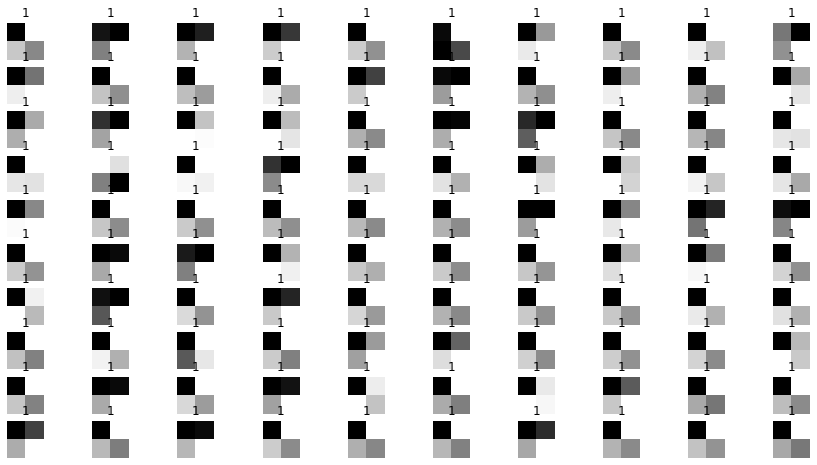

In [6]:
#plot grid pca of x 1
h.plot_grid(x_pca_1,labels=y_pca_1 , rows=10, cols=10)

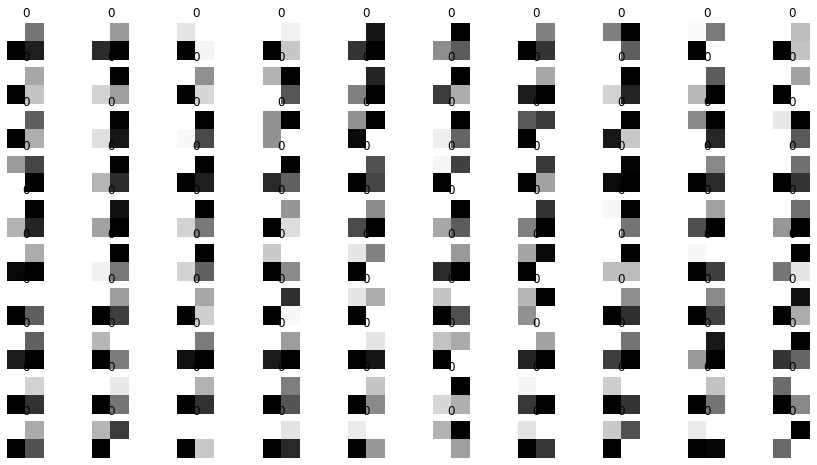

In [7]:
h.plot_grid(x_pca_0.reshape(6903,2,2),labels=[0 for i in range(6903)] , rows=10, cols=10)

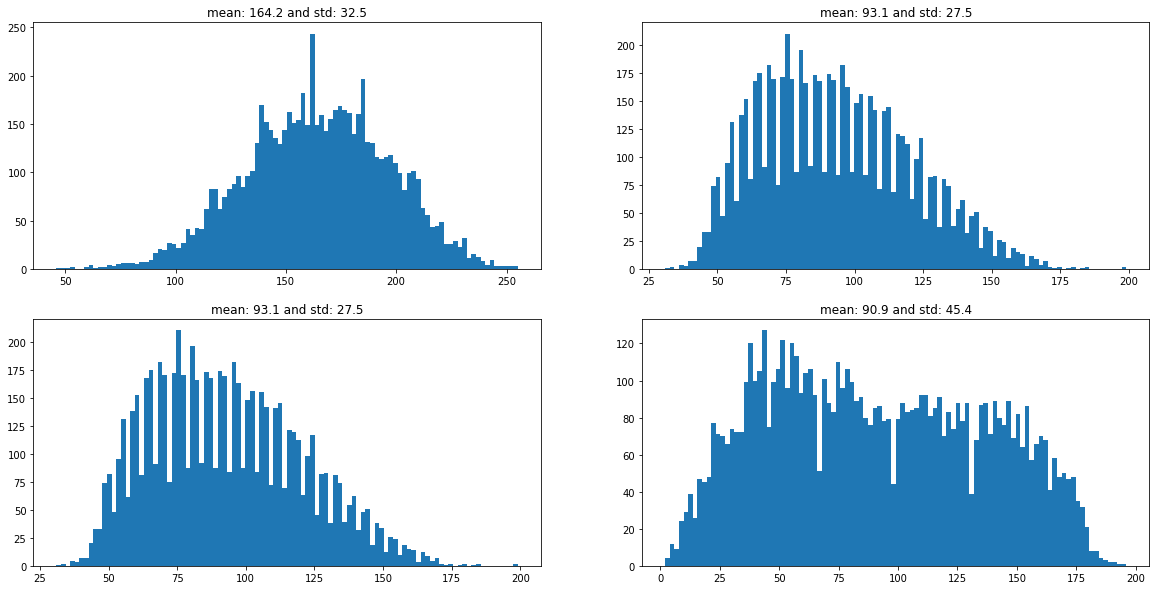

In [8]:
fig , ax = plt.subplots(2,2,figsize=(20,10))

for i in range(2):
    for j in range(2):
        #plot histogram of x_pca_0
        ax[i][j].hist(x_pca_0.reshape(6903,4)[:,i+j],bins=100)
        ax[i][j].set_title("mean: {:.1f} and std: {:.1f}".format(x_pca_0.reshape(6903,4)[:,i+j].mean(),x_pca_0.reshape(6903,4)[:,i+j].std()))

plt.show()

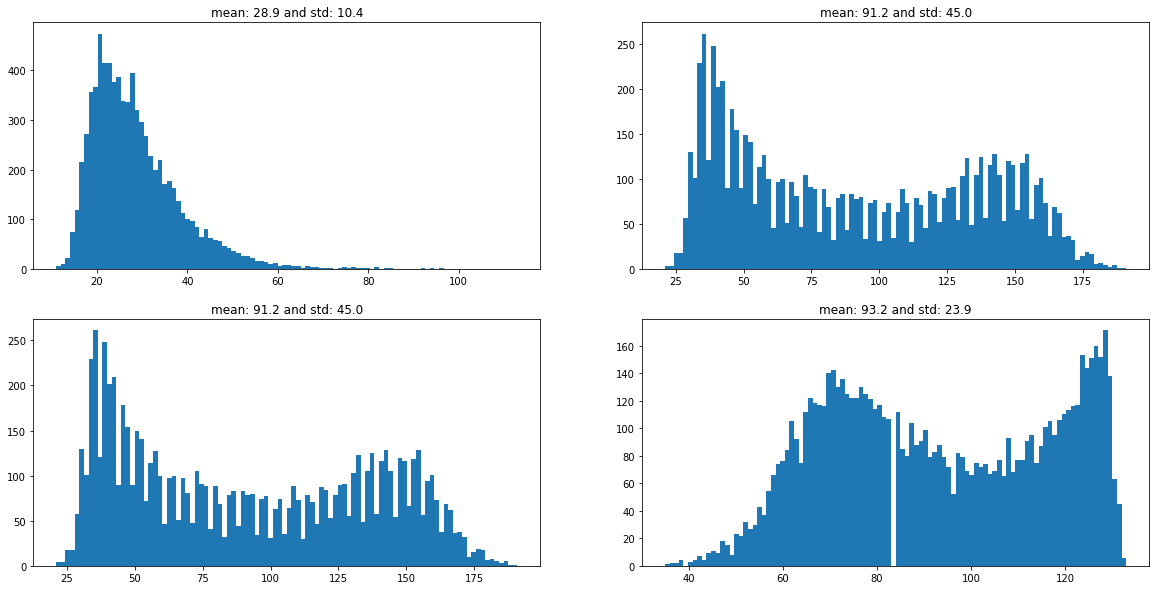

In [9]:
fig , ax = plt.subplots(2,2,figsize=(20,10))

x = x_pca_1.reshape(7877,4)

for i in range(2):
    for j in range(2):
        #plot histogram of x_pca_0
        ax[i][j].hist(x[:,i+j],bins=100)
        ax[i][j].set_title("mean: {:.1f} and std: {:.1f}".format(x[:,i+j].mean(),x[:,i+j].std()))

plt.show()

Weiss bedeutet wenig information, da die Bilder sich in dem Pixel nicht/wenig unterscheiden => da alle in dem Pixel eher dunkel bzw weiss sind

je dunkler desto mehr information, da die Bilder sich in dem Pixel unterscheiden

=> daraus folgt, dass je heller der punkt, desto mehr ist dieser Pixel ein Merkmal der Klasse (das immer gleich bleibt)

man weiss nun nur, ob der pixel immer gleich ist und noch nicht ob sich dieser Eignet um die Klassen zu trennen. Problem ist, wenn beide zB Links oben eine geringe Entropie haben, also ein markantes Merkmal für die Klasse, aber den selben Farbwert(also beide Schwarz). Wenn also beide Klassen immer links oben schwarz sind, haben Sie dort zwar jeweilse eine hohe Entropie, allerdings kann man sie anhand von diesem Merkmal nicht unterscheiden.


wie man unten sieht, fallen die pixel die die meiste veränderung haben nicht zusammen, jedoch hat class 0 links oben auch "nur" einen leicht blauen wert, was für leichte variantion spricht.  
Nimmt man zusätzlich das Mittlere Bild pro Klasse, sieht man dass links oben auch der pixel ist, in dem sich die Klassen (im mittel) am meisten unterscheiden

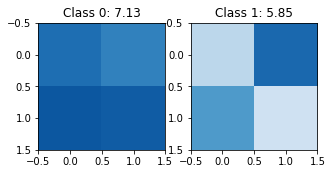

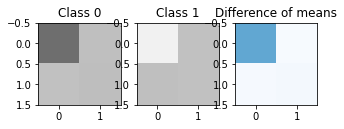

0.3597455320677324 0.5304002108373462     pixel 0  =  0.19080910605651857
0.156461014609787 0.007386508214799636     pixel 1  =  0.0011557005697110777
0.20696826518723832 0.009103759201689154     pixel 2  =  0.001884189248655962
0.3995180460540204 0.01736405748173825     pixel 3  =  0.00693725431667376


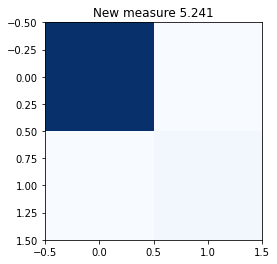

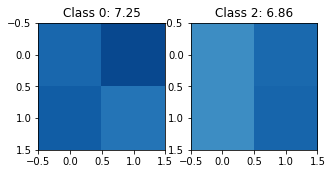

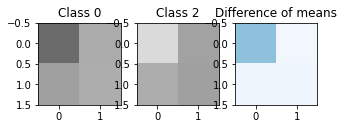

0.1785542877236751 0.412332526648807     pixel 0  =  0.07362374060108101
0.10998033946136465 0.02492400109138676     pixel 1  =  0.002741150100766139
0.17962025556828354 0.04481227483925887     pixel 2  =  0.00804919225922384
0.13252031470113734 0.04091409885622488     pixel 3  =  0.005421949256140365


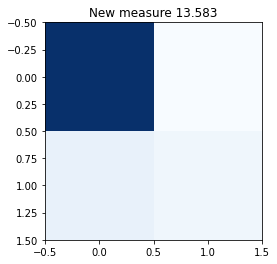

In [56]:
for subset in itertools.combinations([i for i in range(10)],2):
   
    x = all_numbers["x"][(all_numbers["y"] == subset[0]) | (all_numbers["y"] == subset[1])]
    y = all_numbers["y"][(all_numbers["y"] == subset[0]) | (all_numbers["y"] == subset[1])]

    x_pca = h.PCA(x,n_components=4)
    x_pca = h.normalize(x_pca,min=0,max=255,dtype=int)
    
    y_unique = np.unique(y)
    fig,ax = plt.subplots(1,len(y_unique),figsize=(5,5))
    i = 0
    entropies = list()
    for y_class in y_unique:
        x_class = x_pca[y == y_class]
        entropy = cm.entropy(x_class)
        entropies.append(entropy)
        ax[i].set_title("Class {}: {:.2f}".format(y_class,entropy.mean()))
        ax[i].imshow(entropy.reshape(2,2),cmap="Blues",vmin=4,vmax=8)
        i+=1

    plt.show()

    x_pca = h.normalize(x_pca,min=0,max=1,dtype=float)
    
    fig,ax = plt.subplots(1,len(y_unique)+1,figsize=(5,5))
    i = 0

    means = list()
    for y_class in y_unique:
        x_class = x_pca[y == y_class]
        x_class_mean = x_class.mean(axis=0)
        means.append(x_class_mean)
        ax[i].set_title("Class {}".format(y_class))
        #vmin und vmax sind die Werte für die Farbskala (cmap)
        ax[i].imshow(x_class_mean.reshape(2,2),cmap="Greys",vmin=0,vmax=1)
        i+=1    
   
    #show difference of means in image 
    mean_diff = np.abs(np.array(means[0]) - np.array(means[1]))
    ax[-1].imshow(mean_diff,cmap="Blues",vmin=0,vmax=1)
    ax[-1].set_title("Difference of means")
    plt.show()
    mean_diff = mean_diff.flatten()

    #wenn die pixelwerte für das feature gleichverteilt sind, jeder gray scale kommt genau einmal vor
    max_entropy = -sum(1/256 * np.log2(1/256) for _ in range(256))
    #wenn die pixelwerte für das feature immer gleich sind, immer der selbe gray scale value
    min_entropy = (-1 * np.log2(1))

  

    new_measure = np.zeros(4)
    for i in range(4):
        #min of entropy of both classes
        min_entropy_pixel = np.min([entropies[0][i],entropies[1][i]])

        #inverse entropy and scale
        min_entropy_pixel = (max_entropy-min_entropy_pixel+min_entropy) / max_entropy

        print(min_entropy_pixel,mean_diff[i],"    pixel",i," = ",  min_entropy_pixel*mean_diff[i])

        new_measure[i] = min_entropy_pixel*mean_diff[i]
    
    plt.imshow(new_measure.reshape(2,2),cmap="Blues")
    plt.title("New measure {:.3f}".format(1/(np.amax(new_measure))))
    plt.show()
   


    if subset == (0,2):
        break
    

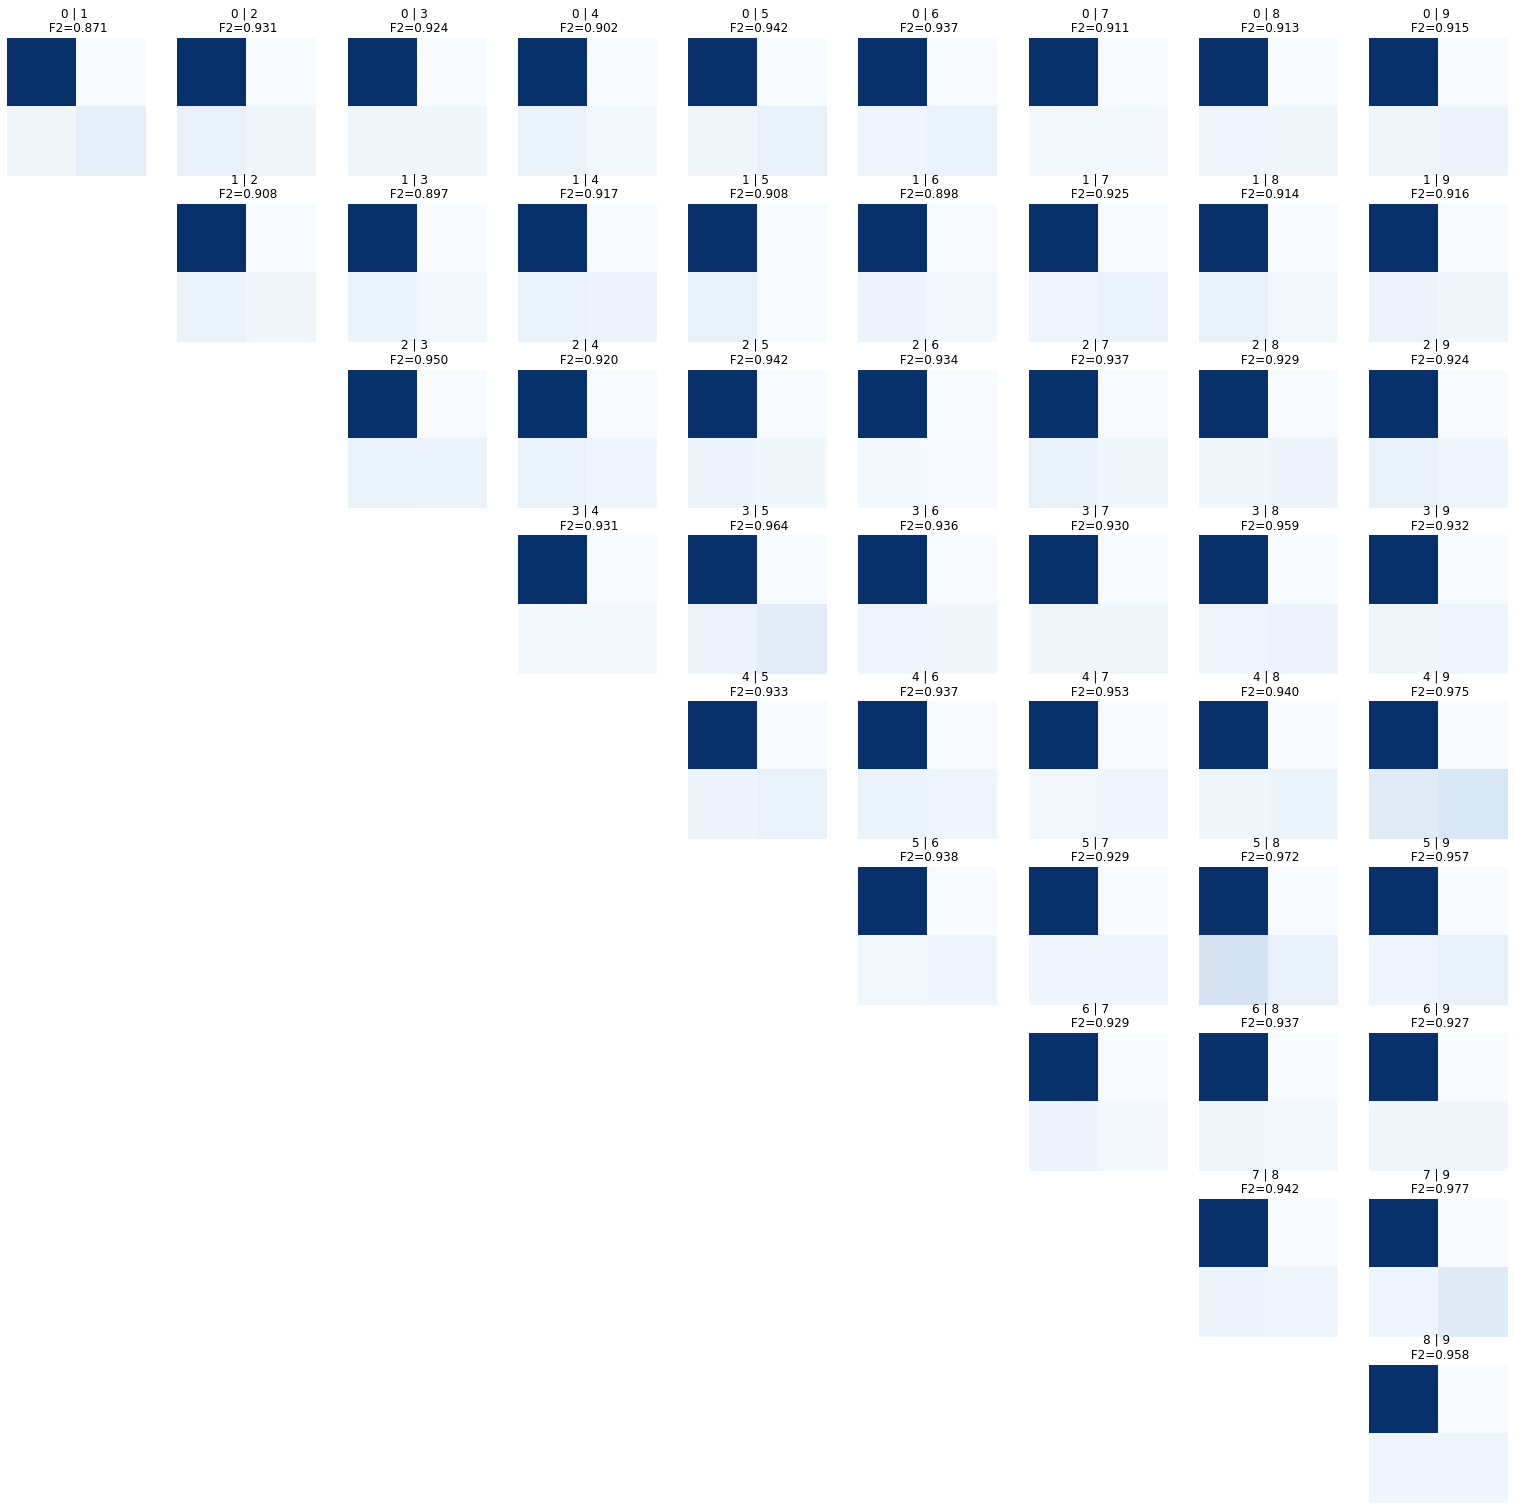

In [67]:
fig,ax = plt.subplots(10,10,figsize=(30,30))

results = dict()

for subset in itertools.combinations([i for i in range(10)],2):
   
    x = all_numbers["x"][(all_numbers["y"] == subset[0]) | (all_numbers["y"] == subset[1])]
    y = all_numbers["y"][(all_numbers["y"] == subset[0]) | (all_numbers["y"] == subset[1])]

    x_pca = h.PCA(x,n_components=4)
    x_pca = h.normalize(x_pca)
    
    y_unique = np.unique(y)
   
    entropies = list()
    for y_class in y_unique:
        x_class = x_pca[y == y_class]
        entropy = cm.entropy(x_class)
        entropies.append(entropy)
        
    means = list()
    for y_class in y_unique:
        x_class = x_pca[y == y_class]
        x_class_mean = x_class.mean(axis=0)
        means.append(x_class_mean)
   

    #wenn die pixelwerte für das feature gleichverteilt sind, jeder gray scale kommt genau einmal vor
    max_entropy = -sum(1/256 * np.log2(1/256) for _ in range(256))
    #wenn die pixelwerte für das feature immer gleich sind, immer der selbe gray scale value
    min_entropy = (-1 * np.log2(1))

    new_measure = np.zeros(4)


    for i in range(4):
       #min of entropy of both classes
        min_entropy_pixel = np.min([entropies[0][i],entropies[1][i]])

        #inverse entropy and scale
        min_entropy_pixel = (max_entropy-min_entropy_pixel+min_entropy) / max_entropy

        new_measure[i] = min_entropy_pixel*mean_diff[i]
    
    ax[subset[0],subset[1]].axis("off")
    ax[subset[0],subset[1]].set_title("{} | {} \n F2={:.3f}".format(subset[0],subset[1],1/(np.amax(1+new_measure))))
    ax[subset[0],subset[1]].imshow(new_measure.reshape(2,2),cmap="Blues")

    results[str(subset)] = np.amax(1/(1+np.amax(new_measure)))

# hide combinations with empty plots
for i in range(10):
    for j in range(i+1):
        fig.delaxes(ax[i][j])

plt.show()
    

In [64]:
#save results as json
import json
with open("results/entropy.json","w") as f:
    f.write(json.dumps(results))

In [62]:
import operator

#print sorted results by value
sorted_results = sorted(results.items(), key=operator.itemgetter(1),reverse=True)
for k in sorted_results:
    print(k)

('(7, 9)', 0.9773096356131303)
('(4, 9)', 0.9752184418112475)
('(5, 8)', 0.9721332195074501)
('(3, 5)', 0.9638402191901956)
('(3, 8)', 0.9593623537986532)
('(8, 9)', 0.9578676895263026)
('(5, 9)', 0.9568894211509804)
('(4, 7)', 0.9527316988409308)
('(2, 3)', 0.9500188241939234)
('(0, 5)', 0.942400950741247)
('(7, 8)', 0.9422838175473823)
('(2, 5)', 0.9417430338335937)
('(4, 8)', 0.9401754791039145)
('(5, 6)', 0.937903520968252)
('(2, 7)', 0.9373935040106656)
('(0, 6)', 0.9367323164132523)
('(4, 6)', 0.9365933256744099)
('(6, 8)', 0.9365405403937278)
('(3, 6)', 0.9362452750384336)
('(2, 6)', 0.933752123488131)
('(4, 5)', 0.9326297033645427)
('(3, 9)', 0.9318905711023908)
('(0, 2)', 0.9314250069024538)
('(3, 4)', 0.930568609975383)
('(3, 7)', 0.9297885939428618)
('(6, 7)', 0.9291903183154924)
('(2, 8)', 0.9290058993138378)
('(5, 7)', 0.9287427487474593)
('(6, 9)', 0.9267435484326301)
('(1, 7)', 0.9246157422405321)
('(2, 9)', 0.9244339902361961)
('(0, 3)', 0.9235605372843196)
('(2, 4)', 0

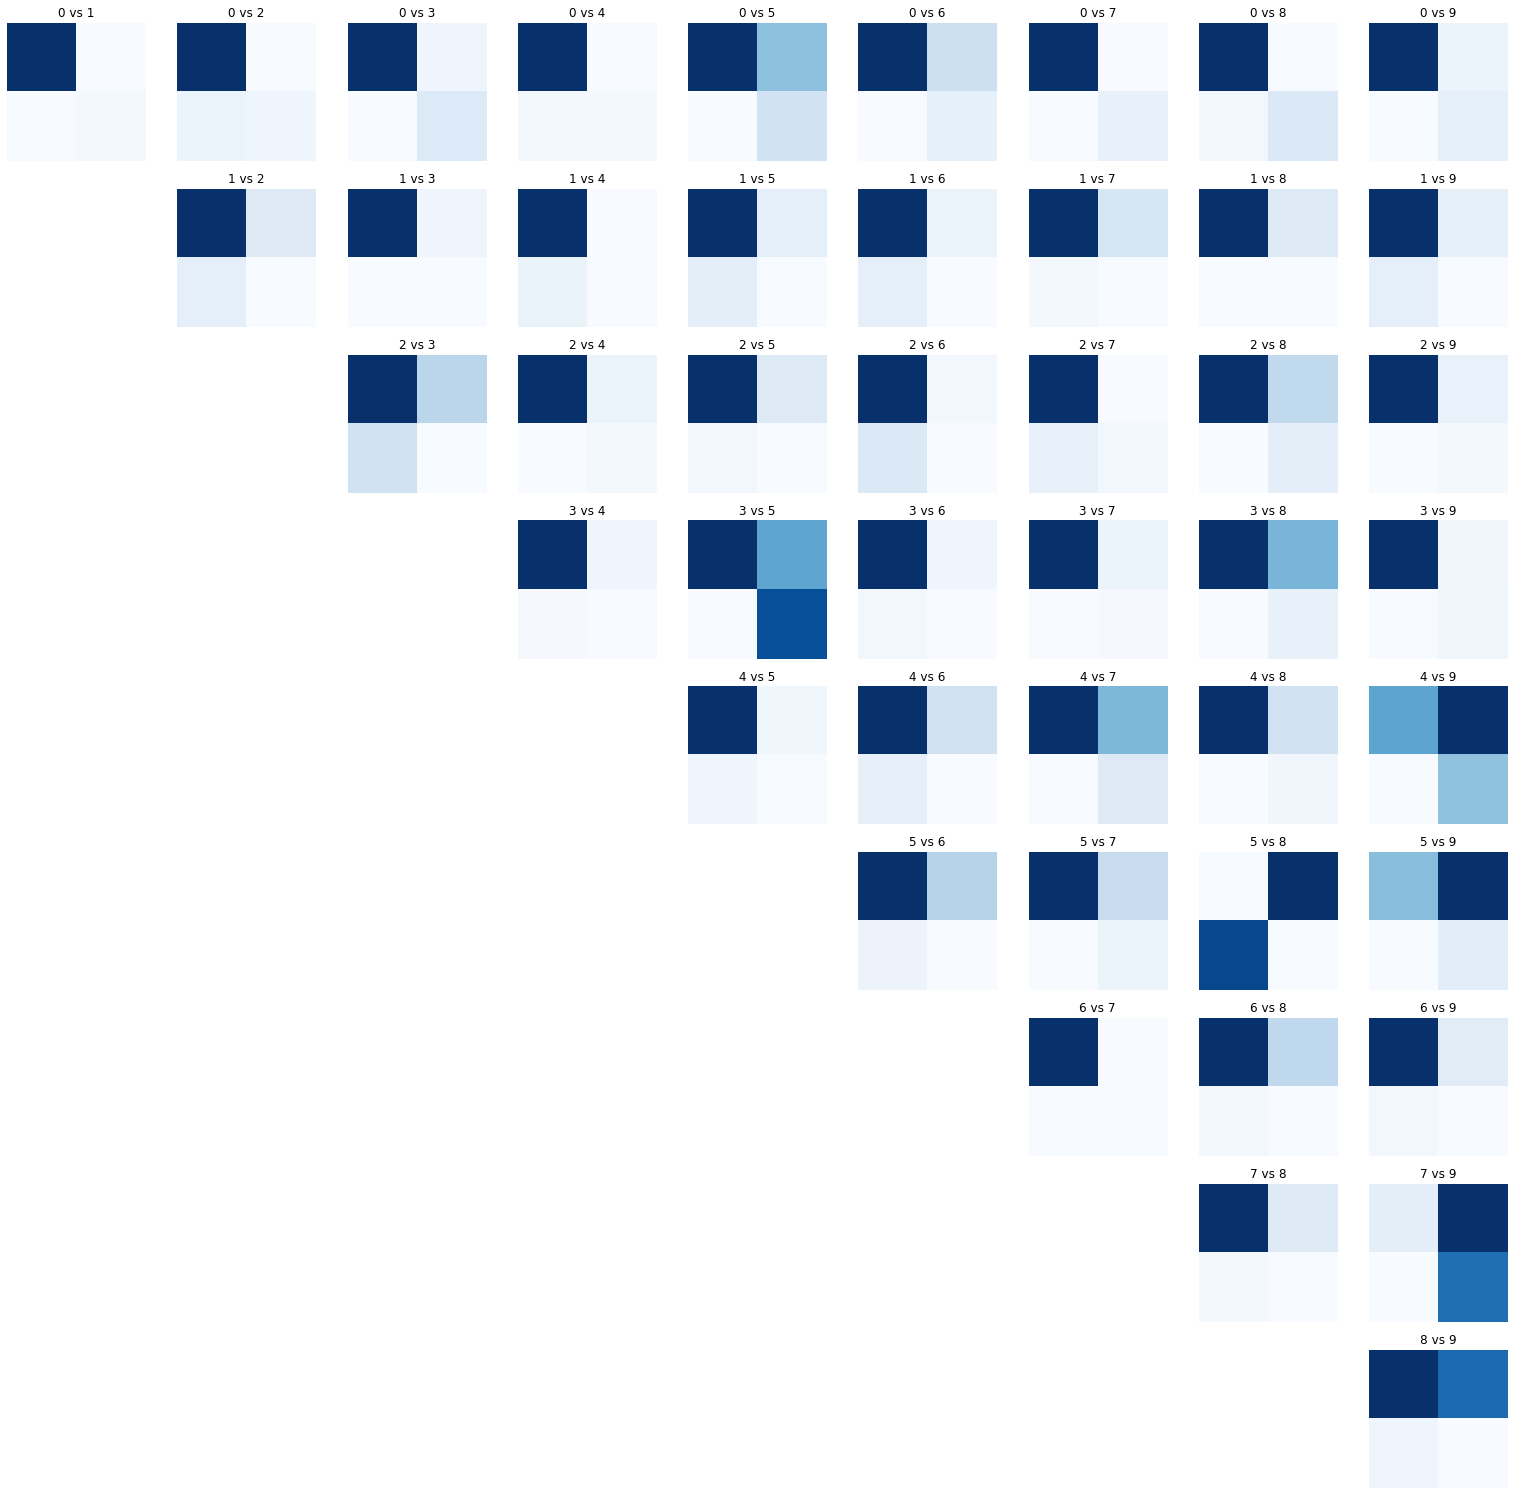

In [23]:
fig,ax = plt.subplots(10,10,figsize=(30,30))

for subset in itertools.combinations([i for i in range(10)],2):
    x = all_numbers["x"][(all_numbers["y"] == subset[0]) | (all_numbers["y"] == subset[1])]
    y = all_numbers["y"][(all_numbers["y"] == subset[0]) | (all_numbers["y"] == subset[1])]

    x_pca = h.PCA(x,n_components=4)
    x_pca = h.normalize(x_pca)
    
    y_unique = np.unique(y)

    mean_diff = np.abs(x_pca[y == subset[0]].mean(axis=0) - x_pca[y == subset[1]].mean(axis=0))


    ax[subset[0],subset[1]].axis("off")
    ax[subset[0],subset[1]].imshow(mean_diff.reshape(2,2),cmap="Blues")
    ax[subset[0],subset[1]].set_title("{} vs {}".format(subset[0],subset[1]))


# hide combinations with empty plots
for i in range(10):
    for j in range(i+1):
        fig.delaxes(ax[i][j])

plt.show()

In [1]:

#safe for later use

for preprocessing in store:
    print(preprocessing)
    for subset in store[preprocessing]["x_train"]:
        x = np.concatenate((store[preprocessing]["x_train"][subset],store[preprocessing]["x_test"][subset]),axis=0)
        y = np.concatenate((store[preprocessing]["y_train"][subset],store[preprocessing]["y_test"][subset]),axis=0)

        print(subset,x.shape,y.shape)

NameError: name 'store' is not defined